# Branch detection performance comparison


This notebook compares several clustering algorithms on their ability to detect
branches in a dataset's manifold that do not contain a local density maximum.
Our synthetic dataset contains several n-point star-shaped clusters and some
uniform random noise. The stars have a density maximum in their centre, and the
density decreases along their arms. A grid search is used to find the
algorithms' optimal parameter values, before their Adjusted Rand Index is used
to compare their performance.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import product
from collections import defaultdict

from scipy import linalg
from sklearn.utils import shuffle
from sklearn.metrics.cluster import adjusted_rand_score

from lib.cdc import CDC
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from fast_hbcc import HBCC, BoundaryClusterDetector
from fast_hdbscan import HDBSCAN, BranchDetector

## Datasets

In [3]:
def make_star(
    num_dimensions=2,
    num_branches=3,
    points_per_branch=100,
    branch_length=2,
    noise_scale=0.02,
):
    """Creates a n-star in d dimensions."""

    def rotation(axis=[0, 0, 1], theta=0):
        return linalg.expm(np.cross(np.eye(3), axis / linalg.norm(axis) * theta))

    def rotate(X, axis=[0, 0, 1], theta=0):
        M = rotation(axis=axis, theta=theta)
        data = np.hstack((X, np.zeros((X.shape[0], 1), dtype=X.dtype)))
        return (M @ data.T).T[:, :2]

    max_exp = np.log(branch_length)
    branch = np.zeros((points_per_branch, 2))
    branch[:, 0] = np.exp(np.linspace(0, max_exp, points_per_branch)) - 1
    branches = np.concatenate(
        [
            rotate(branch, theta=theta)
            for theta in np.linspace(0, 2 * np.pi, num_branches, endpoint=False)
            + np.pi / 2
        ]
    )
    X = np.column_stack((branches, np.zeros((branches.shape[0], num_dimensions - 2))))
    X += np.random.normal(
        scale=np.sqrt(1 / num_dimensions) * noise_scale,
        size=X.shape,
    )
    y = np.repeat(np.arange(num_branches), points_per_branch)
    return X, y


def make_stars_dataset(size_factor=1, num_dimensions=2):
    num_branches = [3, 10, 4, 5]
    branch_lengths = [1.8, 3.5, 2.3, 2]
    points_per_branch = [40, 100, 150, 20]
    noise_scales = [0.2, 0.1, 0.2, 0.02]
    origins = np.array(
        [
            [7, 1],
            [2, 3],
            [5.5, 3],
            [7, 5],
        ]
    )

    # Make individual starts
    Xs, ys = zip(
        *[
            make_star(
                num_dimensions=num_dimensions,
                num_branches=nb,
                branch_length=l,
                points_per_branch=int(np * size_factor),
                noise_scale=s,
            )
            for l, np, nb, s in zip(
                branch_lengths, points_per_branch, num_branches, noise_scales
            )
        ]
    )

    # Concatenate to one dataset
    X = np.concatenate(
        [
            x + np.concatenate((o, np.zeros(num_dimensions - 2)))
            for x, o in zip(Xs, origins)
        ]
    )
    y = np.concatenate([y + nb for y, nb in zip(ys, np.cumsum(num_branches))])

    # Add uniform noise points
    num_noise_points = X.shape[0] // 20
    noise_points = np.random.uniform(
        low=X.min(axis=0), high=X.max(axis=0), size=(num_noise_points, num_dimensions)
    )
    noise_labels = np.repeat(y.max(), num_noise_points)
    X = np.concatenate((X, noise_points))
    y = np.concatenate((y, noise_labels))

    # Shuffle the data
    return shuffle(X, y)

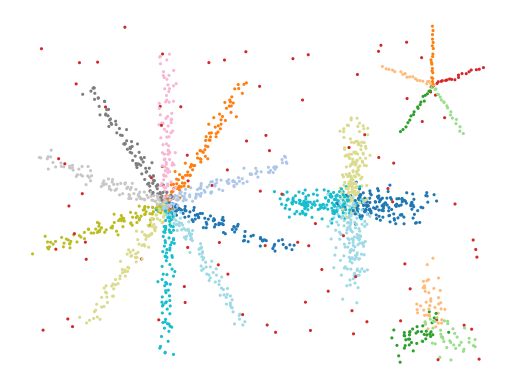

In [4]:
X, y = make_stars_dataset()
plot_kwargs = dict(s=5, cmap="tab20", vmin=0, vmax=19, edgecolors="k", linewidths=0)
plt.scatter(*X.T, c=y % 20, **plot_kwargs)
plt.axis("off")
plt.show()

## Parameter Sweep

In [5]:
algorithms = dict(
    # kmeans=KMeans,
    hdbscan=HDBSCAN,
    hbcc=HBCC,
    # slink=AgglomerativeClustering,
    # spectral=SpectralClustering,
    # cdc=CDC,
)
post_processors = dict(
    flasc=BranchDetector,
    sbcc=BoundaryClusterDetector,
)
static_params = defaultdict(
    dict,
    # slink=dict(linkage="single"),
    # spectral=dict(assign_labels="cluster_qr"),
    flasc=dict(propagate_labels=True)
)

In [6]:
n_hops = [2, 3, 4, 5]
n_clusters = np.round(np.linspace(4, 25, 6)).astype(np.int32)
n_neighbors = np.round(np.linspace(2, 20, 6)).astype(np.int32)
min_cluster_sizes = np.unique(
    np.round(np.exp(np.linspace(np.log(25), np.log(60), 10)))
).astype(np.int32)
selection_methods = ["eom", "leaf"]


dynamic_params = defaultdict(
    dict,
    # kmeans=dict(n_clusters=n_clusters),
    # slink=dict(n_clusters=n_clusters),
    # spectral=dict(n_clusters=n_clusters),
    # cdc=dict(k=n_neighbors, ratio=np.linspace(0.5, 0.95, 2).round(4)),
    hdbscan=dict(
        min_samples=n_neighbors,
        min_cluster_size=min_cluster_sizes,
        cluster_selection_method=selection_methods,
    ),
    hbcc=dict(
        num_hops=n_hops,
        min_samples=n_neighbors,
        min_cluster_size=min_cluster_sizes,
        cluster_selection_method=selection_methods,
    ),
    sbcc=dict(num_hops=n_hops),
)

all_params = {name for params in dynamic_params.values() for name in params.keys()}

In [7]:
# Create output structure
results = {
    "repeat": [],
    "alg": [],
    "ari": [],
    "labels": [],
    **{name: [] for name in all_params},
}


def process_algorithm(X, alg_name, alg_class, **base_kwargs):
    kwargs = static_params[alg_name]
    dynamic_ranges = dynamic_params[alg_name]
    for values in product(*dynamic_ranges.values()):
        params = {param: value for param, value in zip(dynamic_ranges.keys(), values)}
        complete_params = {**base_kwargs, **params}
        cc = alg_class(**kwargs, **params)
        labels = cc.fit_predict(X)

        results["repeat"].append(r)
        results["alg"].append(alg_name)
        results["ari"].append(adjusted_rand_score(y, labels))
        results["labels"].append(labels)

        for name in all_params:
            results[name].append(complete_params.get(name, np.nan))

        if alg_name == "hdbscan":
            for post_name, detector_class in post_processors.items():
                process_algorithm(cc, post_name, detector_class, **params)


for r in tqdm(range(5)):
    # Generate dataset
    X, y = make_stars_dataset()
    np.save(f"data/generated/star_parameter_sweep_X_{r}", X)
    np.save(f"data/generated/star_parameter_sweep_y_{r}", y)

    # Run the parameter sweep
    for alg_name, alg_class in algorithms.items():
        process_algorithm(X, alg_name, alg_class)

# Store the results!
result_df = pd.DataFrame.from_dict(results)
result_df.to_parquet("data/generated/star_parameter_sweep_results.parquet")

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\jelme\Documents\Development\work\fast_hbcc\fast_hbcc\hbcc.py:54: RuntimeWarning: invalid value encountered in divide
  return (
C:\Users\jelme\Documents\Development\work\fast_hbcc\fast_hbcc\hbcc.py:54: RuntimeWarning: invalid value encountered in divide
  return (
C:\Users\jelme\Documents\Development\work\fast_hbcc\fast_hbcc\hbcc.py:54: RuntimeWarning: invalid value encountered in divide
  return (
C:\Users\jelme\Documents\Development\work\fast_hbcc\fast_hbcc\hbcc.py:54: RuntimeWarning: invalid value encountered in divide
  return (
 20%|██        | 1/5 [01:25<05:42, 85.66s/it]C:\Users\jelme\Documents\Development\work\fast_hbcc\fast_hbcc\hbcc.py:54: RuntimeWarning: invalid value encountered in divide
  return (
C:\Users\jelme\Documents\Development\work\fast_hbcc\fast_hbcc\hbcc.py:54: RuntimeWarning: invalid value encountered in divide
  return (
C:\Users\jelme\Documents\Development\work\fast_hbcc\fast_hbcc\hbcc.py:54: RuntimeWarning: invali

## Results

In [8]:
result_df = pd.read_parquet("data/generated/star_parameter_sweep_results.parquet")

#### Plot best labels

In [9]:
best_cases = result_df.loc[result_df.groupby(['alg']).apply(lambda x: x.index[np.argmax(x.ari)]).values]
best_cases.drop(columns=['labels'])

C:\Users\jelme\AppData\Local\Temp\ipykernel_3316\3195776615.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_cases = result_df.loc[result_df.groupby(['alg']).apply(lambda x: x.index[np.argmax(x.ari)]).values]


,repeat,alg,ari,num_hops,cluster_selection_method,min_cluster_size,min_samples
5005,4,flasc,0.457955,NaN,eom,49,6
3197,2,hbcc,0.323427,2.0,leaf,54,13
1200,1,hdbscan,0.157895,NaN,eom,25,2
2654,2,sbcc,0.384061,2.0,eom,28,9


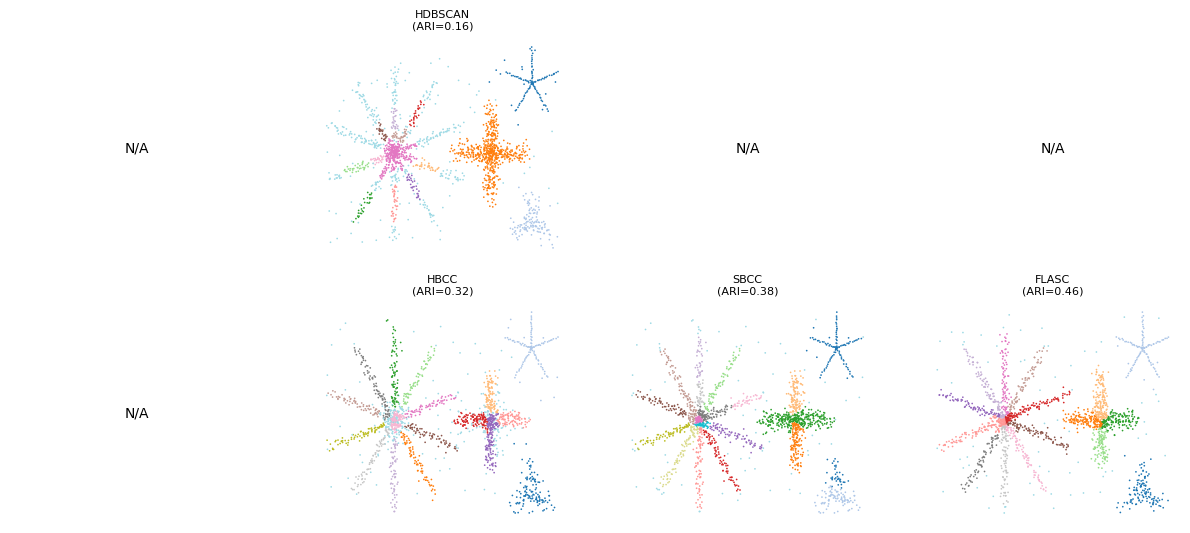

In [10]:
plt.figure(figsize=(12, 6))
algs = ["slink", "hdbscan", "cdc", "kmeans", "spectral", "hbcc", "sbcc", "flasc"]
names = ['SLINK', 'HDBSCAN', 'CDC', 'KMeans', 'Spectral', "HBCC", "SBCC", 'FLASC']
cnt = 1
for alg, alg_name in zip(algs, names):
    plt.subplot(2, 4, cnt)
    plt.xticks([])
    plt.yticks([])
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    cnt += 1
    row = best_cases.query("alg == @alg")
    if row.shape[0] == 0:
        plt.text(0.5, 0.5, "N/A", fontsize=10, ha="center", va="center")
        continue
    plt.title(f"{alg_name}\n(ARI={row.ari.iloc[0]:.2f})", fontsize=8)
    
    plt.scatter(
        *np.load(
            f"data/generated/star_parameter_sweep_X_{row.repeat.iloc[0]}.npy"
        )[:, :2].T,
        s=1.5,
        c=row.labels.iloc[0] % 20,
        cmap="tab20",
        vmin=0,
        vmax=19,
        edgecolors="none",
        linewidths=0,
    )
plt.subplots_adjust(left=0.025, right=1, top=0.92)
plt.show()

### Average ARI

In [11]:
avg_df = result_df.query("repeat == 0")[["alg", *all_params]].copy()
avg_df["ari"] = np.mean(
    np.stack([result_df.query("repeat == @i").ari.values for i in range(5)]),
    axis=0,
)

best_avg = avg_df.loc[
    avg_df.groupby(["alg"]).apply(lambda x: x.index[np.argmax(x.ari)]).values
].sort_values(["alg"])

C:\Users\jelme\AppData\Local\Temp\ipykernel_3316\3020684404.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_df.groupby(["alg"]).apply(lambda x: x.index[np.argmax(x.ari)]).values


#### kMeans, SLINK, Spectral

In [12]:
plt.figure(figsize=(4, 2))
avg_df[~np.isnan(avg_df.n_clusters)].pivot(
    index="n_clusters", columns="alg", values="ari"
).plot(xlabel="Num. clusters", ylabel="ARI", linestyle=":", marker="o", ax=plt.gca())
plt.legend(
    ["kMeans", "SLINK", "Spectral"], title="Algorithm", borderaxespad=0, frameon=False
)
plt.xticks(n_clusters)
plt.ylim(0, 0.5)
plt.title("kMeans, SLINK, Spectral")
plt.show()

AttributeError: 'DataFrame' object has no attribute 'n_clusters'

<Figure size 400x200 with 0 Axes>

#### HDBSCAN

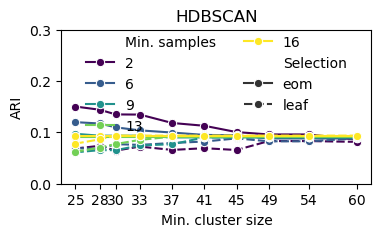

In [13]:
import seaborn as sns

plt.figure(figsize=(4, 2))
sns.lineplot(
    avg_df.query("alg == 'hdbscan' and min_samples < 20").rename(
        columns=dict(min_samples="Min. samples", cluster_selection_method="Selection")
    ),
    style="Selection",
    marker="o",
    x="min_cluster_size",
    y="ari",
    hue="Min. samples",
    palette="viridis",
)
legend = plt.legend(ncols=2, borderaxespad=0, frameon=False)
plt.title("HDBSCAN")
plt.xticks(min_cluster_sizes)
plt.xlabel("Min. cluster size")
plt.ylabel("ARI")
plt.ylim(0, 0.3)
plt.show()

#### FLASC

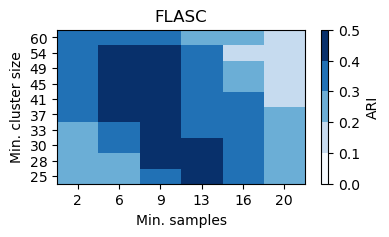

In [14]:
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm

bounds = np.linspace(0, 0.5, 6)
cmap = mpl.colormaps["Blues"]
norm = BoundaryNorm(bounds, cmap.N)

flasc2d = avg_df.query("alg=='flasc' and cluster_selection_method=='eom'")

plt.figure(figsize=(4, 2))
plt.imshow(
    flasc2d.pivot(index="min_cluster_size", columns="min_samples", values="ari"),
    origin="lower",
    aspect="auto",
    cmap=cmap,
    norm=norm,
)
plt.xticks(range(len(n_neighbors)))
plt.yticks(range(len(min_cluster_sizes)))
plt.gca().set_xticklabels([f"{int(x)}" for x in n_neighbors])
plt.gca().set_yticklabels([f"{int(x)}" for x in min_cluster_sizes])

plt.xlabel("Min. samples")
plt.ylabel("Min. cluster size")

plt.title("FLASC")
plt.colorbar(label="ARI")
plt.show()

#### HBCC

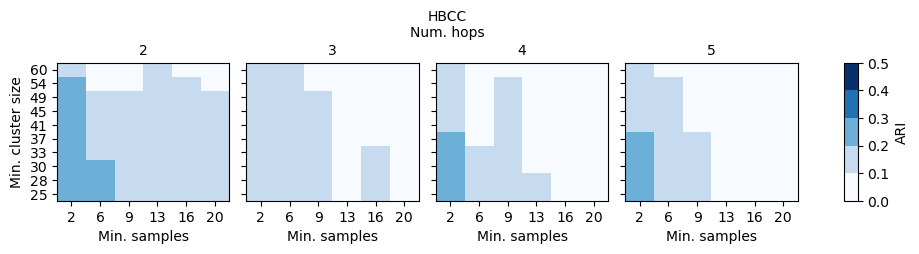

In [15]:
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm

plt.figure(figsize=(12, 2))

bounds = np.linspace(0, 0.5, 6)
cmap = mpl.colormaps["Blues"]
norm = BoundaryNorm(bounds, cmap.N)

hbcc2d = avg_df.query("alg=='hbcc' and cluster_selection_method=='eom'")

for i, bs in enumerate(n_hops):
    plt.subplot(1, 5, i + 1)
    plt.imshow(
        hbcc2d.query("num_hops == @bs").pivot(
            index="min_cluster_size", columns="min_samples", values="ari"
        ),
        origin="lower",
        aspect="auto",
        cmap=cmap,
        norm=norm,
    )
    plt.xticks(range(len(n_neighbors)))
    plt.yticks(range(len(min_cluster_sizes)))
    plt.gca().set_xticklabels([f"{int(x)}" for x in n_neighbors])
    plt.gca().set_yticklabels([f"{int(x)}" for x in min_cluster_sizes])

    plt.xlabel("Min. samples")
    if i == 0:
        plt.ylabel("Min. cluster size")
    else:
        plt.gca().set_yticklabels(["" for _ in min_cluster_sizes])
    plt.title(f"{bs}", fontsize=10)

plt.text(
    0.45,
    0.99,
    "HBCC\nNum. hops",
    fontsize=10,
    ha="center",
    va="center",
    transform=plt.gcf().transFigure,
)
ax = plt.subplot(1, 6, 6)
plt.colorbar(ax=ax, aspect=10, pad=0, fraction=1, label="ARI")
plt.axis("off")
plt.subplots_adjust(top=0.8, hspace=0.5, wspace=0.1)
plt.show()

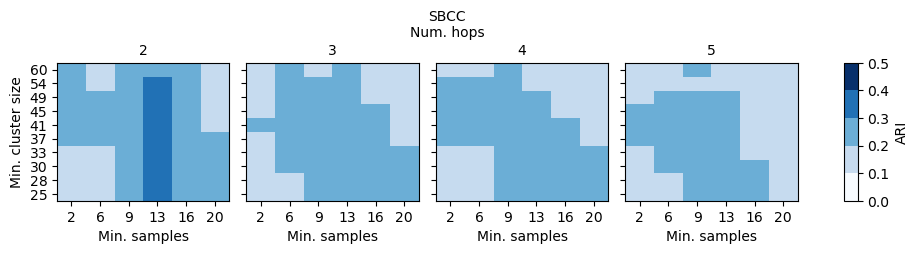

In [16]:
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm

plt.figure(figsize=(12, 2))

bounds = np.linspace(0, 0.5, 6)
cmap = mpl.colormaps["Blues"]
norm = BoundaryNorm(bounds, cmap.N)

sbcc2d = avg_df.query("alg=='sbcc' and cluster_selection_method=='eom'")

for i, bs in enumerate(n_hops):
    plt.subplot(1, 5, i + 1)
    plt.imshow(
        sbcc2d.query("num_hops == @bs").pivot(
            index="min_cluster_size", columns="min_samples", values="ari"
        ),
        origin="lower",
        aspect="auto",
        cmap=cmap,
        norm=norm,
    )
    plt.xticks(range(len(n_neighbors)))
    plt.yticks(range(len(min_cluster_sizes)))
    plt.gca().set_xticklabels([f"{int(x)}" for x in n_neighbors])
    plt.gca().set_yticklabels([f"{int(x)}" for x in min_cluster_sizes])

    plt.xlabel("Min. samples")
    if i == 0:
        plt.ylabel("Min. cluster size")
    else:
        plt.gca().set_yticklabels(["" for _ in min_cluster_sizes])
    plt.title(f"{bs}", fontsize=10)

plt.text(
    0.45,
    0.99,
    "SBCC\nNum. hops",
    fontsize=10,
    ha="center",
    va="center",
    transform=plt.gcf().transFigure,
)
ax = plt.subplot(1, 6, 6)
plt.colorbar(ax=ax, aspect=10, pad=0, fraction=1, label="ARI")
plt.axis("off")
plt.subplots_adjust(top=0.8, hspace=0.5, wspace=0.1)
plt.show()